## Generating advanced image analysis code
In case chatGPT is not aware how to do specific image processing steps, we need to provide further details. In this notebook we ask it to generate code that segments blobs and connects close neighbors using a mesh. This meshing-operation is more challenging and thus, we do it in two attempts: First, we provide a simple prompt just asking for doing it. In a second attempt, we provide details how to do it in more detail.

Note: Executing this notebook multiple times may lead to the OpenAI API crashing with an error mentioning that the service is saturated. It presumably blocks repetetive requests with identical prompts. In that case, wait for some time before trying again.

We define a helper function for making prompts first.

In [1]:
import openai
import matplotlib.pyplot as plt

def prompt(message:str, model="gpt-3.5-turbo"):
    """A prompt helper function that sends a message to openAI
    and returns only the text response.
    """
    client = openai.OpenAI()
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": message}]
    )
    return response.choices[0].message.content

A _simple_ task could be described like in the following. We explictly specify that this should execute from Jupyter to prevent windows popping up.

In [2]:
simple_question = """
Write Python code only and no additional explanatory text.

Write a python program, that 
* loads the file `../../data/blobs.tif`,
* labels objects in this image,
* and draws a mesh between labels with a maximum distance of 50 pixels.

Assume this program would be executed in a Jupyter notebook.
It is not necessary to save the results. Show the results in Jupyter.
"""

The generated code looks like this.

In [3]:
print(prompt(simple_question))

import matplotlib.pyplot as plt
from skimage import io, morphology, measure

# Load the image
image = io.imread('../../data/blobs.tif')

# Threshold the image
thresh = image > 150

# Label objects in the thresholded image
labels = measure.label(thresh)

# Draw a mesh between labels with a maximum distance of 50 pixels
mesh = morphology.dilation(labels) ^ labels

# Show the results
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mesh, cmap='gray')
axes[1].set_title('Mesh between labels')
axes[1].axis('off')
plt.show()


Now we provide more details. We explictly state that the code should be like if it was written by a professional. We also give hints for how to solve the image analysis problem.

In [4]:
more_sophisticated_question = """
Please program some python code like a professional would. 
Write Python code only and no additional explanatory text.

Write a python program, that 
* loads the file `../../data/blobs.tif`,
* labels objects using voronoi-otsu-labeling,
* and draws a mesh between labels with a maximum distance of 50 pixels.

I have this code snippet for segmenting an image:
import pyclesperanto_prototype as cle
label_image = cle.voronoi_otsu_labeling(image)

And this is the code snippet for drawing a mesh between objects in a label image:
mesh = cle.draw_mesh_between_proximal_labels(labels, maximum_distance:int)

Assume this program would be executed in a Jupyter notebook.
It is not necessary to save the results. Show the results in Jupyter.
"""

In [5]:
print(prompt(more_sophisticated_question))

import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt

# Load the image
image = cle.imread('../../data/blobs.tif')

# Label the objects using voronoi-otsu-labeling
label_image = cle.voronoi_otsu_labeling(image)

# Draw a mesh between labels with a maximum distance of 50 pixels
mesh = cle.draw_mesh_between_proximal_labels(label_image, maximum_distance=50)

# Display the label image and mesh
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cle.imshow(image))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cle.imshow(mesh))
plt.title('Mesh Between Labels')
plt.axis('off')

plt.show()


## Batch prompting
We now run the same two prompts multiple times, collect the code and test if it executes successfully.

In [6]:
def test_code(question, num_executions = 10):
    """
    Asks chatGPT for code n times and executes it. 
    It returns the number of attempts when it caused an error and the total number of attempts.
    """
    import time
    import random

    num_errors = 0
    for i in range(num_executions):
        print("Attempt", i + 1)
        
        # sleep for a moment to prevent openAI blocking us right away
        sleep_duration = random.uniform(60, 120)
        time.sleep(sleep_duration)
        
        # ask for code
        code = prompt(question)
        
        # clean it a bit
        code = code.replace("```python", "").replace("```", "")

        # execute it
        try:
            exec(code)
        except:
            num_errors += 1
    return num_errors, num_executions

Attempt 1
Attempt 2
Attempt 3
Attempt 4
Attempt 5
Attempt 6
Attempt 7
Attempt 8
Attempt 9


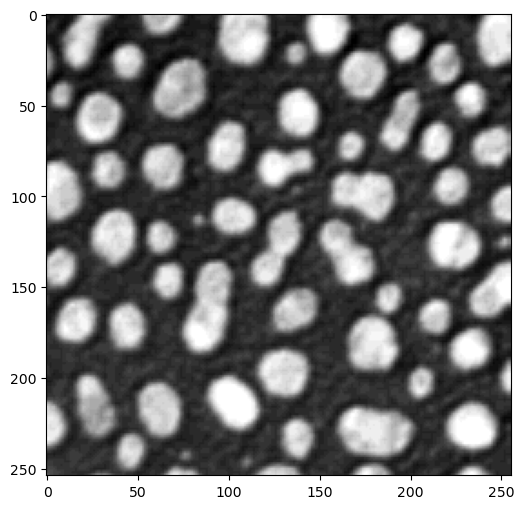

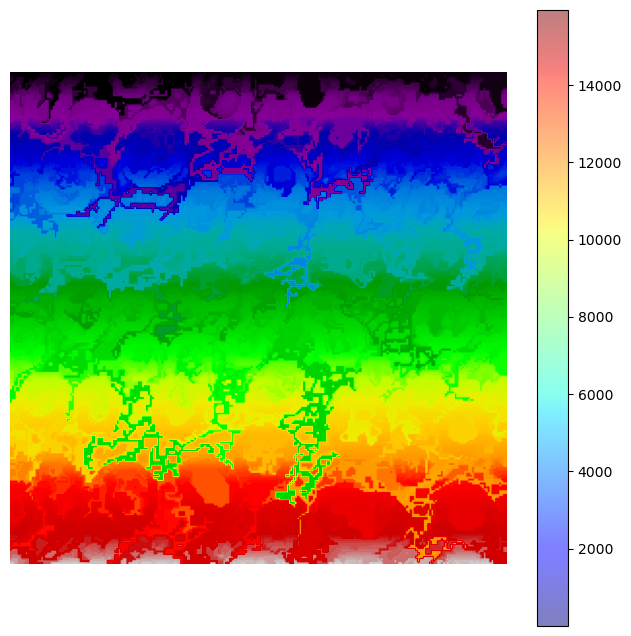

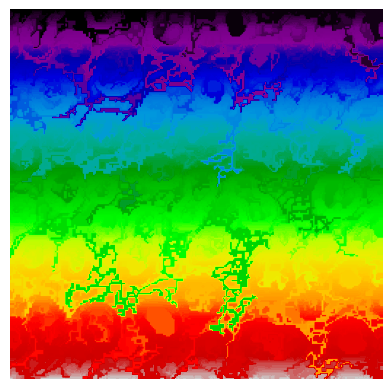

Attempt 10


In [7]:
num_errors_simple, num_executions = test_code(simple_question)

Attempt 1


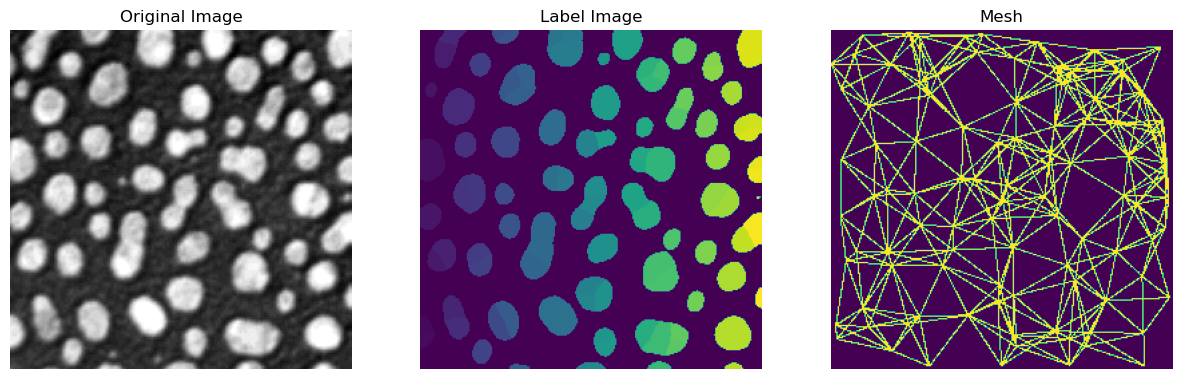

Attempt 2


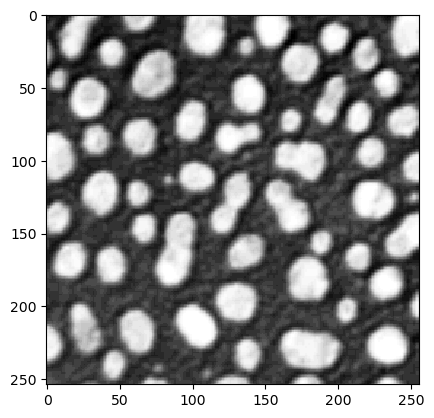

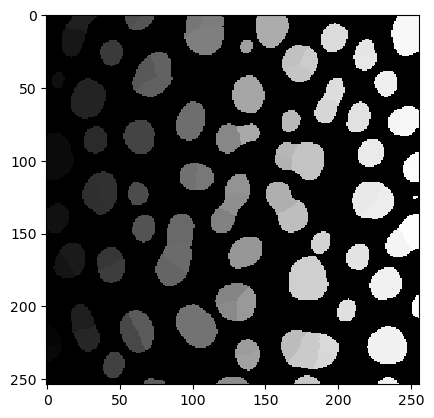

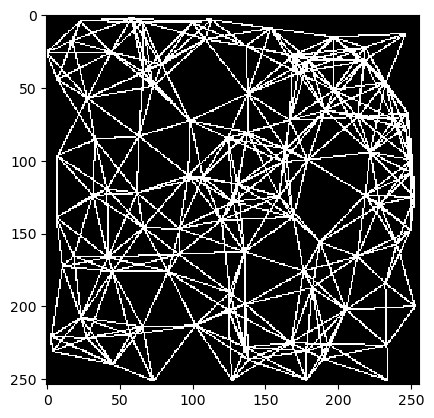

Attempt 3
Attempt 4


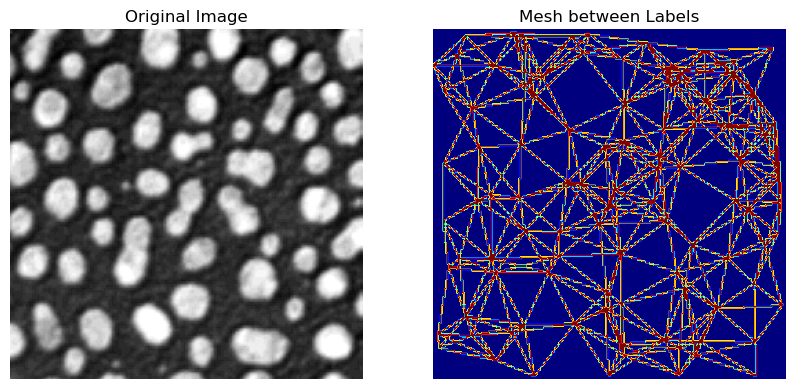

Attempt 5
Attempt 6
Attempt 7
Attempt 8


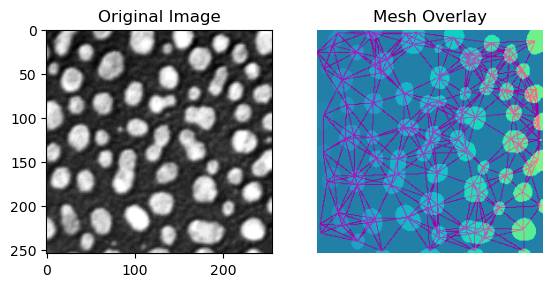

Attempt 9


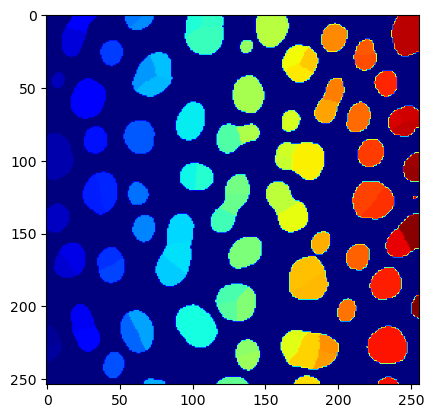

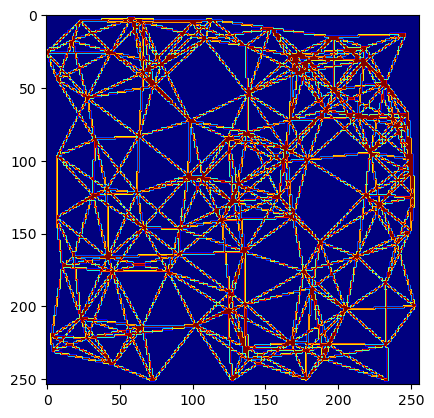

Attempt 10


In [8]:
num_errors_sophisticated, num_executions = test_code(more_sophisticated_question)

In [9]:
print("There were ", 
      num_errors_simple, 
      "errors while executing code after asking the simple question for", 
      num_executions, "times.")

print("There were ", 
      num_errors_sophisticated, 
      "errors while executing code after asking the more sophisticated question for", 
      num_executions, "times.")


There were  9 errors while executing code after asking the simple question for 10 times.
There were  5 errors while executing code after asking the more sophisticated question for 10 times.
